## Семинар 10: "Генерация текстов"

ФИО: 

In [1]:
import numpy as np
import re
from torch import nn
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import sys
from IPython.display import clear_output
from tqdm.autonotebook import tqdm
import progressbar
%matplotlib inline

In [10]:
!wget https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt

--2021-04-09 16:50:15--  https://raw.githubusercontent.com/alvations/Quotables/master/author-quote.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5615127 (5.4M) [text/plain]
Saving to: ‘author-quote.txt’

author-quote.txt    100%[===================>]   5.35M  25.2MB/s    in 0.2s    

2021-04-09 16:50:17 (25.2 MB/s) - ‘author-quote.txt’ saved [5615127/5615127]



Этот семинар посвящен чат-ботам. Вам предстоит реализовать модель, генерирующую определенные тексты. В качестве текстов можно взять сборник цитат умных людей, предсказаний и т.д. На семинаре мы используем данные https://github.com/alvations/Quotables/blob/master/author-quote.txt

При реализации задания вы можете пользоваться кодом из этого примера: <a href=https://github.com/spro/practical-pytorch/blob/master/char-rnn-generation/char-rnn-generation.ipynb>Generating Shakespeare with a Character-Level RNN</a>

### Часть 1: подготовка данных

Реализуйте датасет для дальнейшего обучения (будем использовать batch size=1)

In [33]:
lines = [
    x.split('\t')[1].strip() ##!!!!!
    for x in open('author-quote.txt').readlines()
]
lines = [l.lower().replace(".", "").replace(",", "").replace("?", "").replace("!", "").replace("'", " ").split() for l in lines if l != ""]

In [34]:
lines[3]

['organizing',
 'is',
 'what',
 'you',
 'do',
 'before',
 'you',
 'do',
 'something',
 'so',
 'that',
 'when',
 'you',
 'do',
 'it',
 'it',
 'is',
 'not',
 'all',
 'mixed',
 'up']

In [35]:
[(len(l), l) for l in sorted(lines, key=len)]

[(2, ['holy', 'cow']),
 (3, ['adventure', 'is', 'worthwhile']),
 (3, ['example', 'is', 'leadership']),
 (3, ['keep', 'it', 'simple']),
 (3, ['self-plagiarism', 'is', 'style']),
 (3, ['i', 'feel', 'old']),
 (3, ['i', 'expected', 'results']),
 (3, ['character', 'is', 'power']),
 (3, ['humor', 'is', 'healing']),
 (3, ['work', 'begets', 'work']),
 (3, ['make', 'haste', 'slowly']),
 (3, ['casseroles', 'are', 'one-pot-wonders']),
 (3, ['i', 'love', 'glee']),
 (3, ['o', 'mores', ')']),
 (3, ['elegance', 'is', 'refusal']),
 (3, ['self-realization', 'is', 'great']),
 (3, ['i', 'm', 'bisexual']),
 (3, ['politics', 'is', 'cyclical']),
 (3, ['i', 'am', 'reactive']),
 (3, ['humility', 'is', 'truth']),
 (3, ['i', 'became', 'stereotyped']),
 (3, ['always', 'educate', 'yourself']),
 (3, ['americans', 'never', 'quit']),
 (3, ['be', 'obscure', 'clearly']),
 (3, ['excellence', 'always', 'sells']),
 (3, ['racing', 'amuses', 'me']),
 (3, ['living', 'is', 'abnormal']),
 (3, ['forgotten', 'is', 'forgiven']),

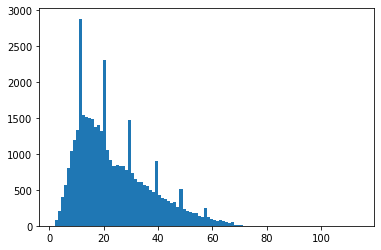

In [21]:
plt.hist(list(map(len, lines)), bins=100);

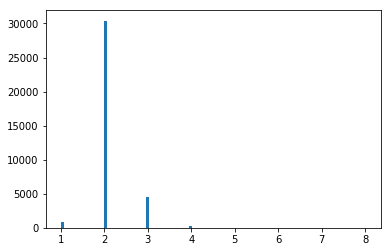

In [ ]:
plt.hist(list(map(lambda x: len(x.split()), lines)), bins=100);

In [ ]:
line = lines[0]

In [ ]:
line

'A. A. Milne'

In [ ]:
# lines = list(
#     filter(lambda x: len(x.split()) <= 50,
#            lines)
# )

In [24]:
np.random.seed(777)
torch.manual_seed(777)

In [25]:
class Vocabulary:
    def __init__(self, sentences):
        all_characters = set()
        for line in sentences:
            all_characters |= set(line)
        all_characters = list(sorted(all_characters))+['<eos>', '<go>']
        self.char_to_id = {
            x[1]:x[0]
            for x in enumerate(all_characters)
        }
        self.id_to_char = {
            x[0]:x[1]
            for x in enumerate(all_characters)
        }
        self.size = len(all_characters)

    def encode(self, line):
        return [self.char_to_id[x] for x in line]
    
    def decode(self, tokens):
        return ' '.join([self.id_to_char[x] for x in tokens])

In [36]:
vocab = Vocabulary(lines)

In [31]:
len(lines)

39269

In [37]:
len(vocab.char_to_id)

32063

In [28]:
lines[0]

['if',
 'you',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'i',
 'want',
 'to',
 'live',
 'to',
 'be',
 'a',
 'hundred',
 'minus',
 'one',
 'day',
 'so',
 'i',
 'never',
 'have',
 'to',
 'live',
 'without',
 'you']

In [29]:
vocab.decode(vocab.encode(lines[0]))

'if you live to be a hundred i want to live to be a hundred minus one day so i never have to live without you'

In [27]:
assert vocab.decode(vocab.encode(lines[0])) == lines[0]

AssertionError: ignored

In [38]:
class Quotes(Dataset):
    def __init__(self, sentences, vocab):
        # Construct vocabulary + EOS & GO tokens
        self.sentences = sentences
        self.vocab = vocab
        self.go = self.vocab.char_to_id['<go>']
        self.eos = self.vocab.char_to_id['<eos>']

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = self.vocab.encode(self.sentences[idx])
        _input = np.array([self.go]+tokens)
        _output = np.array(tokens+[self.eos])
        return _input, _output

In [42]:
def compose_batch(batch):
    lengths = np.array([len(x[0]) for x in batch])
    order = np.argsort(-lengths)
    go = torch.zeros(len(batch), lengths[order[0]]).long()
    eos = torch.zeros(len(batch), lengths[order[0]]).long()
    mask = torch.zeros(len(batch), lengths[order[0]]).long()
    for i in range(len(batch)):
        current_go, current_eos = batch[i]
        go[i, :len(current_go)] = torch.tensor(current_go)
        eos[i, :len(current_eos)] = torch.tensor(current_eos)
        mask[i, :len(current_go)] = 1
    mask = mask[order]
    go = go[order]
    eos = eos[order]
    lengths = lengths[order]
    return go, eos, mask, lengths

In [40]:
dataset = Quotes(lines, vocab)

In [41]:
dataloader = DataLoader(
    dataset, shuffle=True,
    batch_size=128,
    collate_fn=compose_batch)

In [87]:
import gensim.downloader

#w2v = gensim.downloader.load('word2vec-google-news-300')
w2v = gensim.downloader.load('glove-twitter-25')

matrix = []
for w_id in tqdm(range(len(vocab.id_to_char))):
     word = vocab.id_to_char[w_id]
     if word not in w2v:
       emb = w2v["_"]
     else:
       emb = w2v[word]

     matrix.append(emb)

In [85]:
w2v.most_similar("good")

[('too', 0.9648016095161438),
 ('day', 0.9533665180206299),
 ('well', 0.9503172039985657),
 ('nice', 0.9438973069190979),
 ('better', 0.9425961375236511),
 ('fun', 0.9418926239013672),
 ('much', 0.9413353204727173),
 ('this', 0.9387556314468384),
 ('hope', 0.9383507370948792),
 ('great', 0.9378515481948853)]

### Часть 2: определение модели

In [101]:
class Oracle(nn.Module):
    def __init__(self, vocabulary_size,
                 embedding_size=128,
                 hidden_size=256,
                 layers=2):
        super().__init__()

        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(
            vocabulary_size, embedding_size
        )
        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )
        self.classifier = nn.Linear(
            hidden_size, vocabulary_size
        )

    def forward(self, _input, lengths):
        embedding = self.embedding(_input).transpose(0, 1)
        embedding = nn.utils.rnn.pack_padded_sequence(
            embedding, lengths
        )
        output, _ = self.generator(embedding)
        output, _ = nn.utils.rnn.pad_packed_sequence(output)
        classes = self.classifier(output)
        return classes

    def generate(self, vocab, max_len=100):
        h = torch.zeros(self.layers, 1, self.hidden_size)
        current_token = '<go>'
        line = ''
        while (current_token != '<eos>') and \
                len(line) < max_len:
            token = torch.tensor([[vocab.char_to_id[current_token]]]).long()
            token_id = token.detach()
            embedding = self.embedding(token_id)
            output, (h) = self.generator(embedding, (h))
            classes = self.classifier(output[0])
            classes_probs = nn.Softmax()(classes)
            sampler = torch.distributions.Categorical(classes_probs[0])
            new_token_id = sampler.sample().data.numpy().item()
            current_token = vocab.id_to_char[new_token_id]
            line = line + current_token + ' '
        return line

class OracleW2V(Oracle):
    def __init__(self, embeddings,
                 hidden_size=256,                 
                 layers=2):    
        nn.Module.__init__(self)

        embedding_size = embeddings.shape[1]
        vocabulary_size = embeddings.shape[0]

        self.embedding_size = embedding_size
        self.layers = layers
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embeddings))
        for param in self.embedding.parameters():
            param.requires_grad = False

        self.generator = nn.GRU(
            embedding_size, hidden_size,
            layers, batch_first=False
        )

        self.project = nn.Linear(
            hidden_size, embedding_size
        )     

        self.classify = nn.Linear(
            embedding_size, vocabulary_size
        )

        self.classifier = nn.Sequential(self.project, self.classify)

        with torch.no_grad():
            self.classify.weight.copy_(torch.from_numpy(embeddings))
        self.classify.weight.requires_grad = False

In [102]:
oracle = OracleW2V(np.array(matrix), hidden_size=64)

In [66]:
oracle = Oracle(vocab.size,
                embedding_size=32,
                hidden_size=64, layers=2)

### Часть 3: обучение модели

In [103]:
#optimizer = torch.optim.RMSprop(
#    oracle.parameters(), lr=0.001, weight_decay=1e-5
#)

optimizer = torch.optim.AdamW(oracle.parameters(), lr=0.01)

In [104]:
criterion = nn.CrossEntropyLoss(reduction='none')

In [105]:
losses = []

In [106]:
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

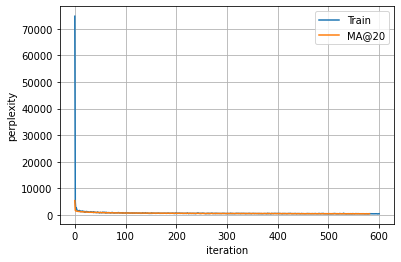

In [110]:
oracle.cuda()

for epoch in range(1):
    bar = progressbar.ProgressBar()
    for i, batch in enumerate(
            tqdm(dataloader, total=len(dataloader))
    ):
        go, eos, mask, length = batch
        go, eos, mask = map(lambda x: x.cuda(), (go, eos, mask))

        oracle.zero_grad()
        prediction = oracle(
            go, length
        ).transpose(0, 1).transpose(1, 2)
        loss = (criterion(prediction, eos)*mask.float()).sum()
        loss = loss / mask.sum()
        loss.backward()

        #[x.grad.clamp_(-1, 1) for x in oracle.parameters() if x.requires_grad]

        optimizer.step()      

        losses.append(np.exp(loss.cpu().item()))

        if i % 50 == 0:
            clear_output(True)
            plt.plot(losses, label='Train')
            plt.plot(moving_average(losses), label='MA@20')
            plt.xlabel('iteration')
            plt.ylabel('perplexity')
            plt.legend()
            plt.grid()
            plt.show()

In [73]:
oracle.cpu()
for _ in range(25):
    print(oracle.generate(vocab))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


every not has word get blair are jungian the when <eos> 
i higher we from ways get been even and nigeria us never have most can became my - was forgiveness greatest 
very is had his and act self-loathing to school 20 ability conscious but costs of <eos> 
molten but decade work afresh the where look that out never diabetes too stand-up harsh have an producers 
abitter problem so this by a desire force t than you for soul; of value question just leadership it 
adichie live time come of other the the kid for gie say work sparse unnatural ve military arrive killing 
i is of secondly which door what is designed you we the of anything maintain i being billiards in the 
i the part tends his everyone blame exterior definiteness we other tv more superior don coming will 
vanities to custom was evident could something ve <eos> 
<eos> 


In [111]:
oracle.cpu()
for _ in range(25):
    print(oracle.generate(vocab))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


the make like world the caps 1870s the el holds protect than germans have mostly reality with it help 
i live being enjoyed other find able go to plan american protagonist and a silent experience alone is 
there used they they afraid have a family my indeed then i grotesques i tell sweetie i only where i 
to nothing temporary found difference my good as poor it were gotten do chance the remarkable work of 
days have sin make only living of m the confusion in of from the adventure the inventor how to to courage 
understand think christmas grace talking a whatever and proved in i the type culty stops with side world 
with to great annoy though to read all finds school it s great great it always course happen now it 
other life is knew completely becoming own frightening the energy the life full what is the the the 
time tea school have day <eos> 
i was time to so be play simulator then i never planning for an too <eos> 
of predictable life either not survive to the city the the face the 

### Часть 4: оценивание модели

<i> Приведите примеры сгенерированных предложений </i>

In [ ]:
plt.plot(losses)

## HW 1 (3 балла)
1. Обучить сеть с LSTM вместо GRU
2. Сделать разбиение train-test и нарисровать графики зависимости перплексии от числа эпох
3. Подобрать гиперпараметры, добиться лучшей перплексии чем с параметрами по умолчанию

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: